<a href="https://colab.research.google.com/github/nandir2512/DeepLearning/blob/main/Autoencoder_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, datasets, models, callbacks
import tensorflow.keras.backend as K

# Parameters

In [ ]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5

# Load Data

In [ ]:
(x_train_1, y_train), (x_test_1, y_test) =  datasets.fashion_mnist.load_data()


These are 28 × 28 grayscale images (pixel values between 0 and 255) out of the box, which we need to preprocess to ensure that the pixel values are scaled between 0 and 1.

# Preprocessing the Data

In [ ]:
def preprocess(imgs):
  # Normalize and reshape the image
  imgs = imgs.astype("float32") / 255.0
  imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0)
  imgs = np.expand_dims(imgs, -1)
  return imgs


In [ ]:
x_train = preprocess(x_train_1)
x_test = preprocess(x_test_1)

In [ ]:
display(x_train)

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [ ]:
display(x_train_1)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

# The Autoencoder Architecture
An autoencoder is a neural network made up of two parts:

* An encoder network that compresses high-dimensional input data such as an image into a lower-dimensional embedding vector

* A decoder network that decompresses a given embedding vector back to the original domain (e.g., back to an image)


# The Encoder

In [ ]:
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name = "encoder_input")
x = layers.Conv2D(32, (3,3), strides = 2, activation='relu', padding="Same")(encoder_input)
x = layers.Conv2D(64, (3,3), strides = 2, activation='relu', padding="same")(x)
x = layers.Conv2D(128, (3,3), strides = 2, activation='relu', padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]  ###the decoder will need this!

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name = "encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output)
encoder.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable

To achieve this, we first create an Input layer for the image and pass this through three Conv2D layers in sequence, each capturing increasingly high-level features. We use a stride of 2 to halve the size of the output of each layer, while increasing the number of channels. The last convolutional layer is flattened and connected to a Dense layer of size 2, which represents our two-dimensional latent space.

# The Decoder

In [ ]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128,(3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)

decoder_output = layers.Conv2D(
    CHANNELS,
     (3,3),
    strides = 1,
    activation= "sigmoid",
    padding = "same",
    name = "decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 32)       1846

Standard convolutional layers allow us to halve the size of an input tensor in both dimensions (height and width), by setting strides = 2.

The convolutional transpose layer uses the same principle as a standard convolutional layer (passing a filter across the image), but is different in that setting strides = 2 doubles the size of the input tensor in both dimensions.

In Keras, the Conv2DTranspose layer allows us to perform convolutional transpose operations on tensors. By stacking these layers, we can gradually expand the size of each layer, using strides of 2, until we get back to the original image dimension of 32 × 32.

# Autoencoder -Joining the Encoder to the Decoder

In [ ]:
autoencoder = models.Model(encoder_input, decoder(encoder_output)) #decoder(encoder_output)
autoencoder.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_4 (Functional)        (None, 32, 32, 1)         2462


The Keras Model that defines the full autoencoder—a model that takes an image and passes it through the encoder and back out through the decoder to generate a reconstruction of the original image.

# Train the autoencoder
Compile the autoencoder

In [ ]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Training the autoencoder


In [ ]:
autoencoder.fit(x_train, x_train, epochs = EPOCHS, batch_size=BATCH_SIZE,
                shuffle = True, validation_data = (x_test, x_test),
               )

Epoch 1/5
600/600 [==============================] - 10s 11ms/step - loss: 0.2977 - val_loss: 0.2671
Epoch 2/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2614 - val_loss: 0.2589
Epoch 3/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2557 - val_loss: 0.2552
Epoch 4/5
600/600 [==============================] - 6s 11ms/step - loss: 0.2528 - val_loss: 0.2532
Epoch 5/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2510 - val_loss: 0.2521


Now that our autoencoder is trained, the first thing we need to check is that it is able to accurately reconstruct the input images.

In [ ]:
# Save the final models
# autoencoder.save("./models/autoencoder")
# encoder.save("./models/encoder")
# decoder.save("./models/decoder")

# Reconstructing Images

In [ ]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [ ]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)



157/157 [==============================] - 1s 3ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[2.86565000e-06],
         [7.11658998e-08],
         [8.56524238e-08],
         ...,
         [9.48318757e-09],
         [1.13181970e-08],
         [9.81263565e-06]],

        [[3.15015711e-07],
         [2.16854557e-09],
         [1.22245218e-08],
         ...,
         [2.06646389e-09],
         [2.45174081e-09],
         [2.43234780e-07]],

        [[1.66916971e-06],
         [3.75521125e-08],
         [3.34596763e-07],
         ...,
         [1.02772765e-06],
         [1.05301233e-07],
         [3.11263602e-06]],

        ...,

        [[1.11236345e-08],
         [4.53388938e-10],
         [7.86372254e-07],
         ...,
         [2.12523901e-07],
         [1.14316663e-08],
         [5.38046692e-08]],

        [[7.94390118e-08],
         [1.57448343e-09],
         [1.98828815e-07],
         ...,
         [4.10068606e-06],
         [1.23755626e-07],
         [1.67056464e-06]],

        [[4.56008056e-05],
         [8.34678190e-07],
         [7.47614104e-06],
         ...,
 

# Embed using the encoder

In [ ]:
embeddings = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [ ]:
#some example of the embeddings
print(embeddings[:10])

[[ 4.5534773e+00  1.8109022e+00]
 [-3.3171048e+00 -1.6758087e+00]
 [ 6.5706449e+00 -1.4344782e+01]
 [ 5.8707275e+00 -9.1937971e+00]
 [-6.9741625e-01 -1.0907540e+00]
 [ 3.3805280e+00 -8.4630461e+00]
 [ 1.2518468e+00 -2.0170860e+00]
 [-4.1718236e-01 -1.6130373e+00]
 [ 7.2068725e+00 -1.8565404e+00]
 [ 6.7152886e+00  1.3671074e-02]]


In [ ]:
# show the encoded points in 2D space

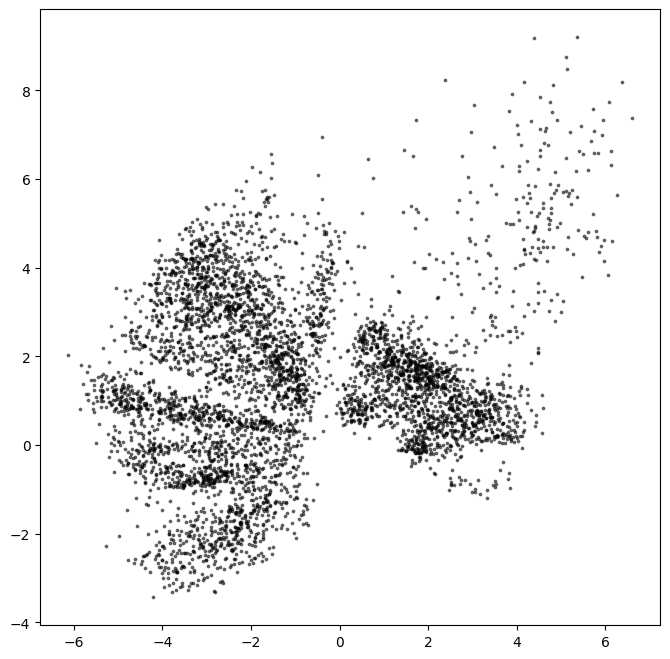

In [ ]:
figsize = 8
plt.figure(figsize = (figsize, figsize))
plt.scatter(embeddings[:,0], embeddings[:,1], c="black", alpha=0.5, s=3)
plt.show()

In order to better understand how this latent space is structured, we can make use of the labels that come with the Fashion-MNIST dataset, describing the type of item in each image. There are 10 groups altogether,

The Fashion-MNIST labels
- ID	Clothing label
* 0     T-shirt/top
* 1     Trouser
* 2     Pullover
* 3     Dress
* 4     Coat
* 5     Sandal
* 6     Shirt
* 7     Sneaker
* 8     Bag
* 9     Ankle Boot








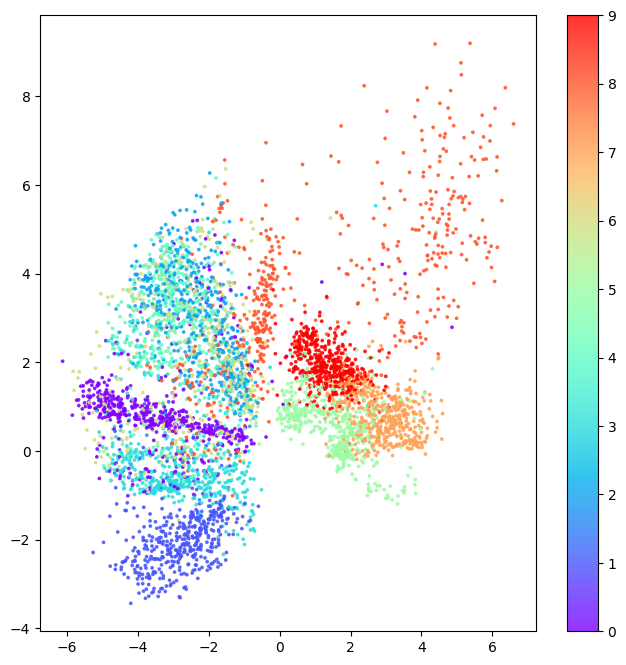

In [ ]:
#colour the embedding by their label (clothing type - see table)

example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0],
            embeddings[:, 1],
            cmap = "rainbow",
            c = example_labels,
            alpha = 0.8,
            s= 3,
            )

plt.colorbar()
plt.show()



# Generate using the decoder

In [ ]:
# Get the range of the existing embeddings

mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis= 0)

#sample some points in the latent space
grid_width, grid_height = (6,3)
sample = np.random.uniform(mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM))



# Decode the sampled points

In [ ]:
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 333ms/step


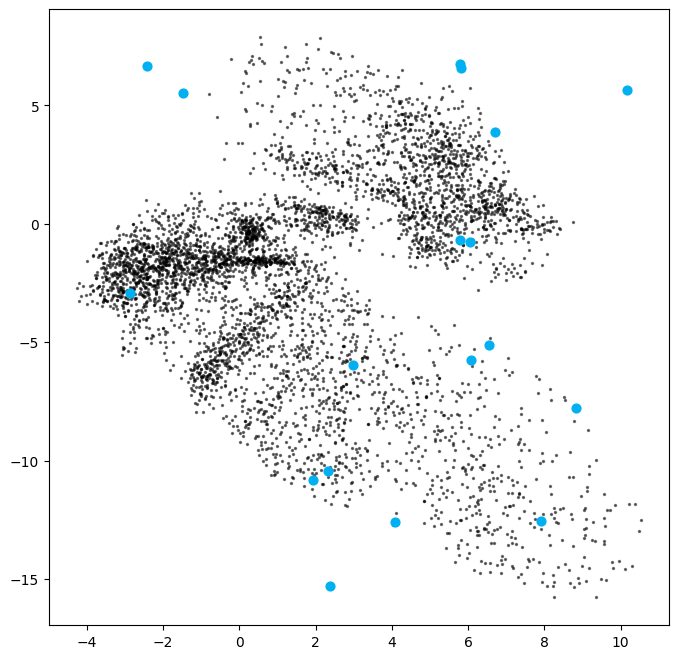

In [ ]:
# Draw a plot of.....

figsize = 8
plt.figure(figsize=(figsize, figsize))


#... the original embeddings....
plt.scatter(embeddings[:, 0], embeddings[:,1], c= "black", alpha=0.5, s= 2)

#... and the newly generated points in the latent space
plt.scatter(sample[:,0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()





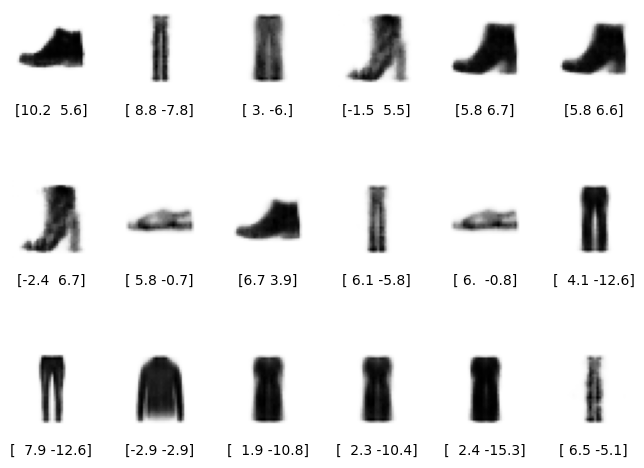

In [ ]:
# Add underneath a grid of the decode images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i in range(grid_width * grid_height):
  ax = fig.add_subplot(grid_height, grid_width, i+1)
  ax.axis("off")
  ax.text(0.5, -0.35, str(np.round(sample[i, :], 1)),
          fontsize=10, ha="center",
          transform=ax.transAxes,
          )
  ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 28ms/step


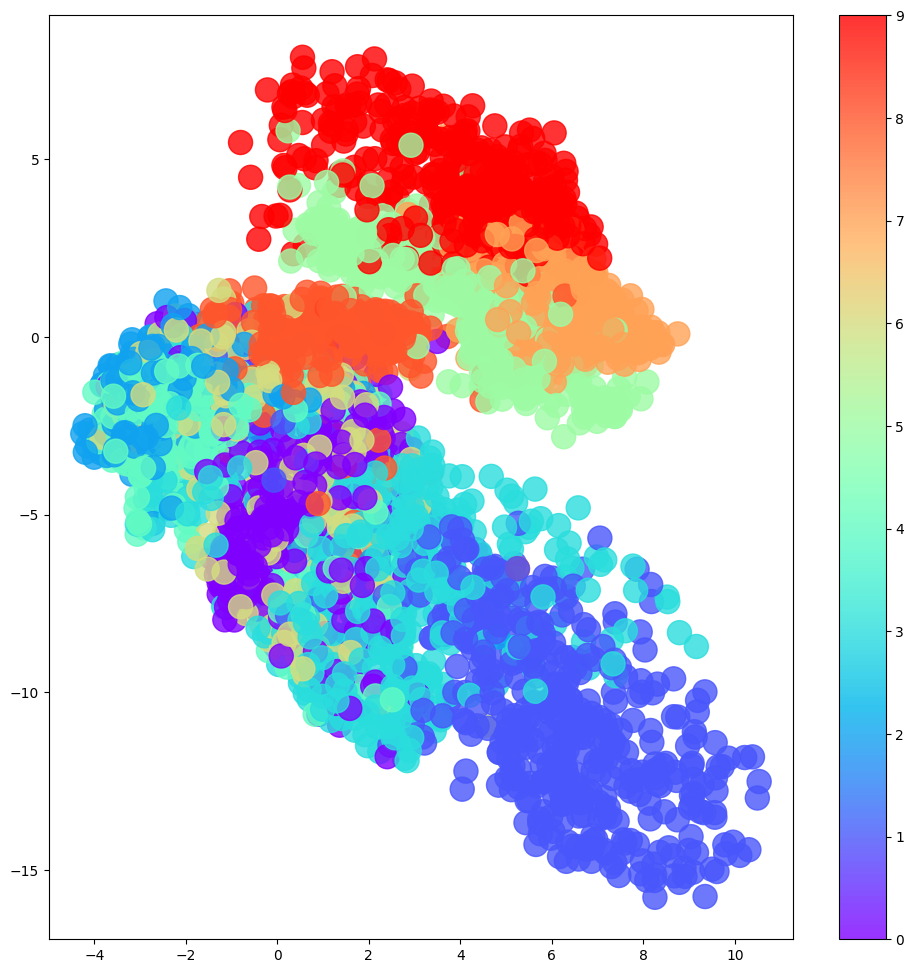

In [ ]:
#Color the embedding by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c= example_labels,
    alpha = 0.8,
    s=300,
)
plt.colorbar()

x=np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y=np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
#plt.scatter(grid[:, 0], grid[:,1], c="black", alpha=1, s=10)
plt.show()

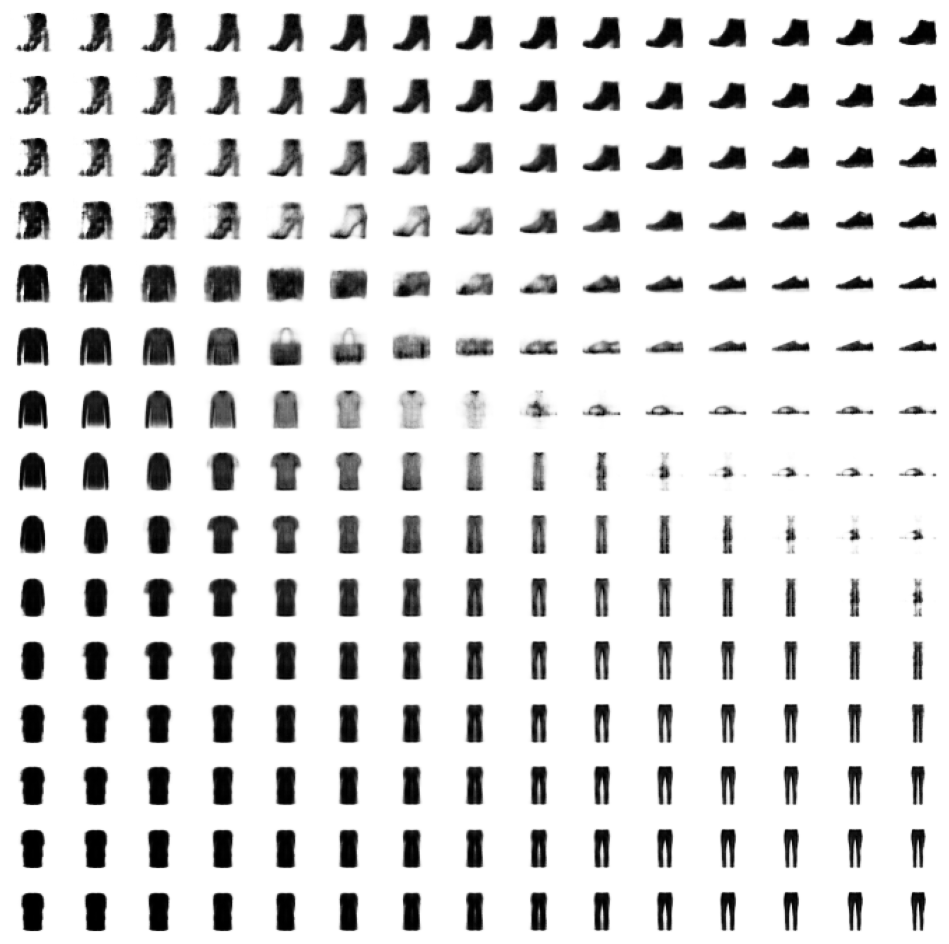

In [ ]:
fig = plt.figure(figsize= (figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
  ax = fig.add_subplot(grid_size, grid_size, i+1)
  ax.axis("off")
  ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 2ms/step


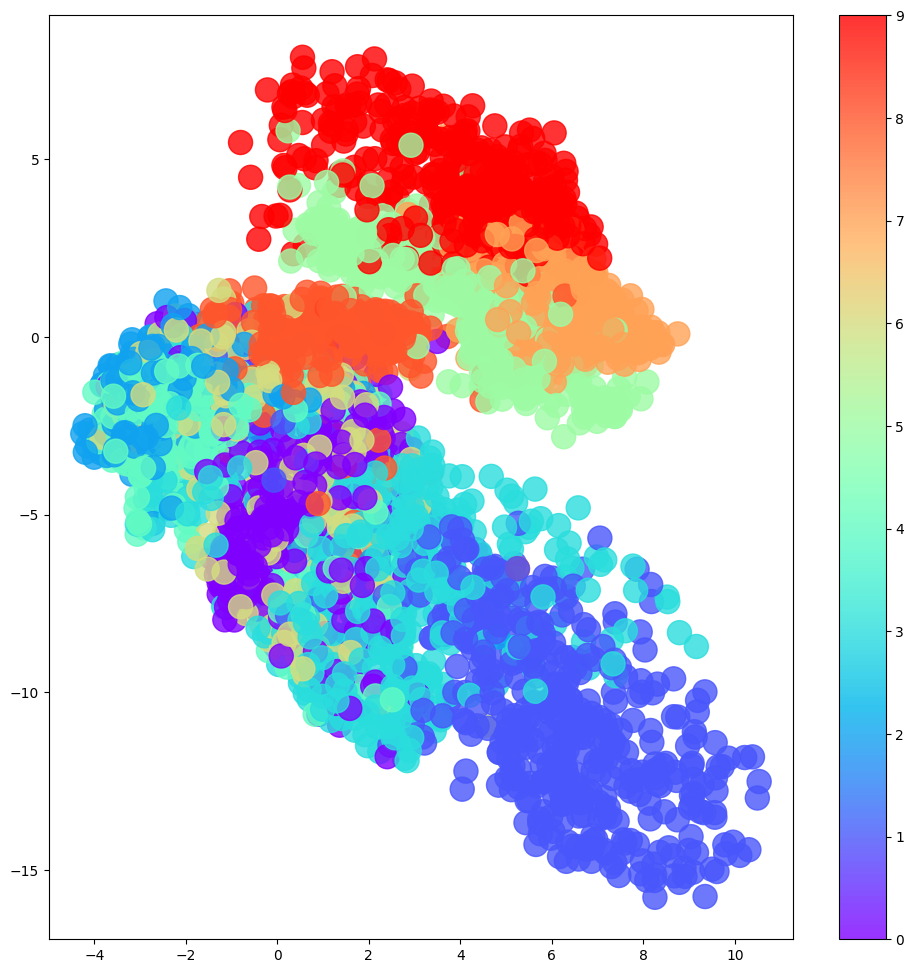

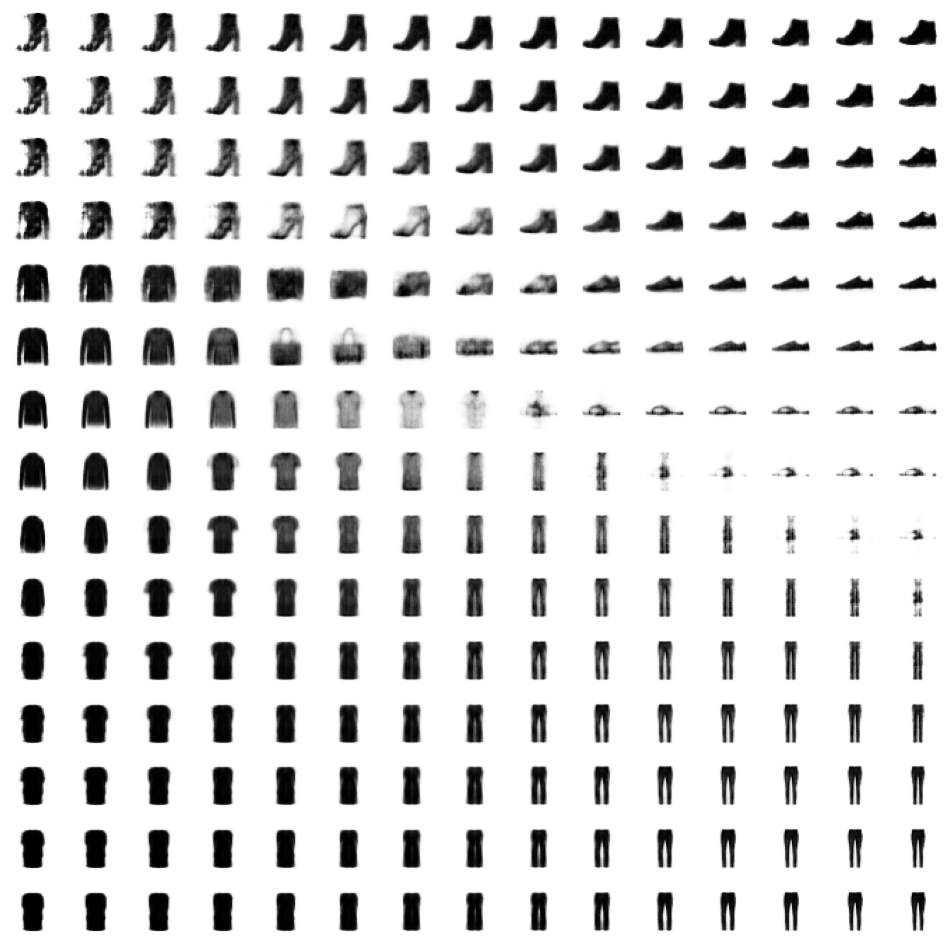

In [ ]:
#Color the embedding by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c= example_labels,
    alpha = 0.8,
    s=300,
)
plt.colorbar()

x=np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y=np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
#plt.scatter(grid[:, 0], grid[:,1], c="black", alpha=1, s=10)
plt.show()


fig = plt.figure(figsize= (figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
  ax = fig.add_subplot(grid_size, grid_size, i+1)
  ax.axis("off")
  ax.imshow(reconstructions[i, :, :], cmap="Greys")